In [1]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
 
%cd ../..

/private/home/pfz/09-videoseal/videoseal-vqvae


In [3]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [17]:
config1024 = load_config("/checkpoint/pfz/projects/autoencoders/ldm/vqgan_imagenet_f16_1024/configs/model_noloss.yaml", display=False)
config16384 = load_config("/checkpoint/pfz/projects/autoencoders/ldm/vqgan_imagenet_f16_16384/configs/model_noloss.yaml", display=False)

model1024 = load_vqgan(config1024, ckpt_path="/checkpoint/pfz/projects/autoencoders/ldm/vqgan_imagenet_f16_1024/checkpoints/last.ckpt")
model16384 = load_vqgan(config16384, ckpt_path="/checkpoint/pfz/projects/autoencoders/ldm/vqgan_imagenet_f16_16384/checkpoints/last.ckpt")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/tmp/ipykernel_351466/3304533457.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


VQGAN --- VQModel: latent shape: torch.Size([64, 64])


VQGAN --- VQModel: latent shape: torch.Size([64, 64])


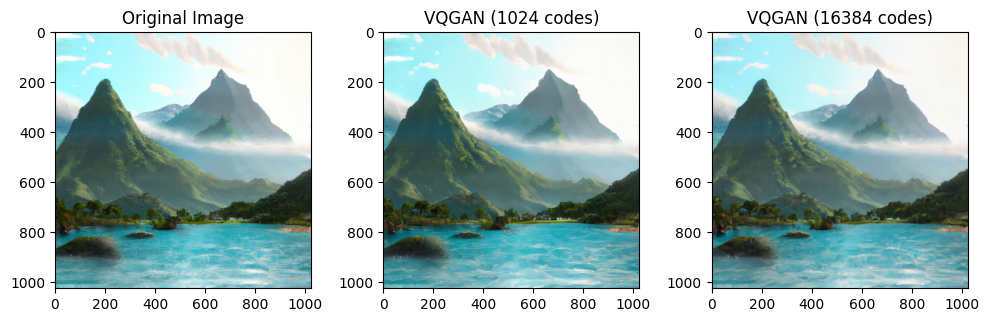

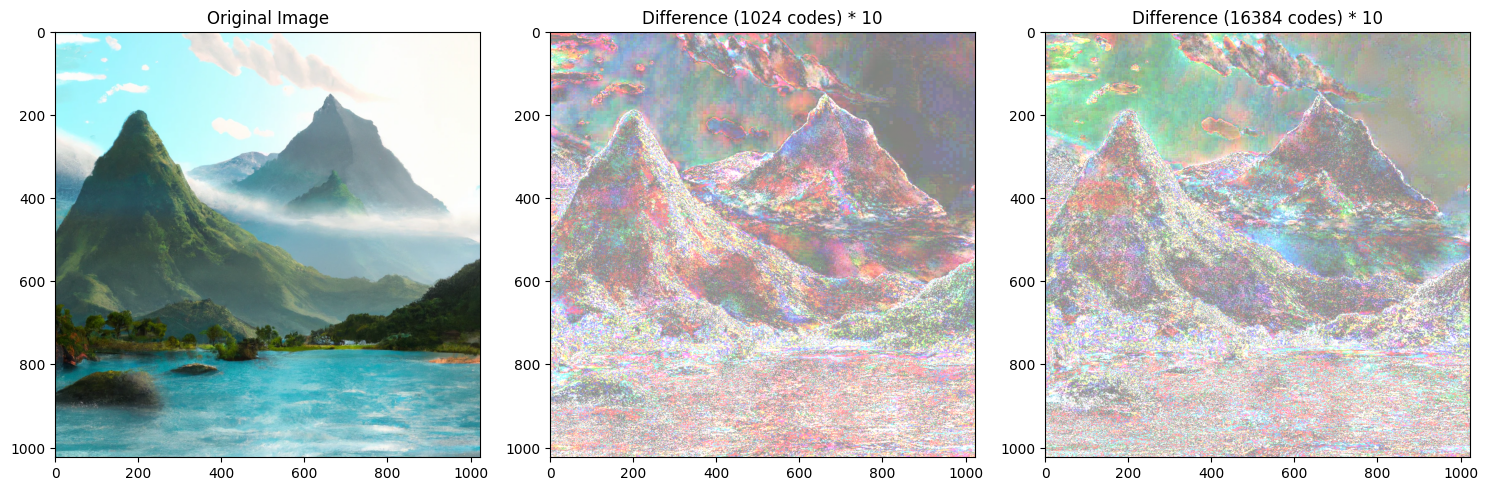

RMSE with 1024 codes: 0.0885
RMSE with 16384 codes: 0.0842


In [19]:
import numpy as np
from PIL import Image
import torch

import matplotlib.pyplot as plt

# Load the image
image_path = "/private/home/pfz/_images/tahiti.png"
image = Image.open(image_path)
image = image.convert("RGB")

# Display original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")

# Convert to tensor and preprocess
x = np.array(image).astype(np.float32) / 255.0
x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0)
x_preprocessed = preprocess_vqgan(x)

# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_preprocessed = x_preprocessed.to(device)
model1024.to(device)
model16384.to(device)

# Reconstruct with model1024
with torch.no_grad():
    reconstructed1024 = reconstruct_with_vqgan(x_preprocessed, model1024)
    reconstructed1024_image = custom_to_pil(reconstructed1024[0])

# Reconstruct with model16384
with torch.no_grad():
    reconstructed16384 = reconstruct_with_vqgan(x_preprocessed, model16384)
    reconstructed16384_image = custom_to_pil(reconstructed16384[0])

# Display reconstructed images
plt.subplot(1, 3, 2)
plt.imshow(reconstructed1024_image)
plt.title("VQGAN (1024 codes)")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed16384_image)
plt.title("VQGAN (16384 codes)")

plt.tight_layout()
plt.show()

# Calculate differences between original and reconstructions
with torch.no_grad():
    # Convert original image to tensor and move to device
    original_tensor = x_preprocessed.clone()
    
    # Calculate absolute differences and scale for visibility
    diff_1024 = torch.abs(original_tensor - reconstructed1024) * 10
    diff_16384 = torch.abs(original_tensor - reconstructed16384) * 10
    
    # Convert to PIL images
    diff_1024_image = custom_to_pil(diff_1024[0])
    diff_16384_image = custom_to_pil(diff_16384[0])

# Display the difference images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(diff_1024_image)
plt.title("Difference (1024 codes) * 10")

plt.subplot(1, 3, 3)
plt.imshow(diff_16384_image)
plt.title("Difference (16384 codes) * 10")

plt.tight_layout()
plt.show()

# Also display the RMSE values
rmse_1024 = torch.sqrt(torch.mean((original_tensor - reconstructed1024) ** 2)).item()
rmse_16384 = torch.sqrt(torch.mean((original_tensor - reconstructed16384) ** 2)).item()

print(f"RMSE with 1024 codes: {rmse_1024:.4f}")
print(f"RMSE with 16384 codes: {rmse_16384:.4f}")